In [8]:
import os, glob, sys
import matplotlib.pyplot as plt
import numpy as np
import h5py
import tensorflow as tf
%matplotlib inline
import skimage
from skimage.io import imread, imshow, imsave
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.optimizers import *
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras import backend as keras
import time
import functools
from eval import *
from ShowColors import *
from ImportUtil import *
%env CITYSCAPES_DATASET = /home/rvygon/data/
from tensorflow.metrics import *
batch_size = 2
%load_ext autoreload
%autoreload 2


env: CITYSCAPES_DATASET=/home/rvygon/data/


In [58]:
def shifted_image(image, label, width_shift_range, height_shift_range):
    """horisontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random_uniform([], -width_shift_range * img_shape[1], width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random_uniform([], -height_shift_range * img_shape[0], height_shift_range * img_shape[0])
        image = tf.contrib.image.translate(image, [width_shift_range, height_shift_range])
        label = tf.contrib.image.translate(label, [width_shift_range, height_shift_range])
    return image, label

def flip_img(horizontal_flip, image, label):
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        image, label = tf.cond(tf.less(flip_prob, 0.5),
                                   lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),
                                   lambda: (image, label))
    return image, label            

def crop_img(crop_rate, image, label):
    if crop_rate is not None:
        image = tf.image.resize_images(tf.image.central_crop(image, crop_rate), (img_shape[0], img_shape[1]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        label = tf.image.resize_images(tf.image.central_crop(label, crop_rate), (img_shape[0], img_shape[1]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, label

def _augment(image,
             label,
             hue_delta=0,
             horisontal_flip=False,
             width_shift_range=0,
             height_shift_range=0,
             crop_rate=None):
    if hue_delta:
        image = tf.image.random_hue(image, hue_delta)
    image, label = flip_img(horisontal_flip, image, label)
    image, label = shifted_image(image, label, width_shift_range, height_shift_range)
    image, label = crop_img(crop_rate, image, label)
    return image, label
def to_tensor(image, label):
    return image, label

def get_dataset(images, labels,
                preproc_fn=functools.partial(_augment),
                threads=5,
                batch_size=batch_size,
                shuffle=True):
    num_x = len(images)
    features_placeholder = tf.placeholder(images.dtype, images.shape)
    labels_placeholder = tf.placeholder(labels.dtype, labels.shape)

    dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
    dataset = dataset.repeat().batch(batch_size)
   
    #dataset = dataset.map(to_tensor, num_parallel_calls=threads)
   # dataset = dataset.map(preproc_fn)
#     if shuffle:
#         dataset = dataset.shuffle(num_x)
    
   
   

    return dataset

In [19]:
#run this cell once
#%run  cityscapesscripts/preparation/createTrainIdLabelImgs
def upd_print(str):
            sys.stdout.write('\r')       
            sys.stdout.write(str)
            sys.stdout.flush()
def multi_dice_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    assert len(y_true.shape) == 4
    assert len(y_pred.shape) == 4
    
    ones = tf.ones_like(y_true)
    p0 = y_pred
    p1 = ones - y_pred
    g0 = y_true
    g1 = ones - y_true

    mult = tf.reduce_sum(tf.multiply(p0, g0), (0, 1, 2))
    den = mult + alpha * tf.reduce_sum(tf.multiply(p0, g1), (0, 1, 2)) + beta * tf.reduce_sum(tf.multiply(p1, g0), (0, 1, 2))
    T = tf.reduce_sum(mult / den)
    max_value = tf.keras.backend.cast(tf.shape(y_true).shape[-1], 'float32')
    return max_value - T

In [10]:
img_shape = (256, 512, 3)
batch_size = 1
total_size = 20
val_size = 5
scale_rate = 4
verbose = 1
start_index = 0

In [11]:
x_train_data, y_train_data = importBatch(total_size, start_index, verbose,'train', scale_rate)
from tensorflow.python.keras.utils import to_categorical
y_train_data = to_categorical(y_train_data)
x_train_data = x_train_data.astype('uint8')
y_train_data = y_train_data.astype('uint8')


x_val_data, y_val_data, files = importBatch(val_size, start_index, verbose, 'val', scale_rate)
y_val_data = to_categorical(y_val_data)
x_val_data = x_val_data.astype('uint8')
y_val_data = y_val_data.astype('uint8')


In [6]:
#UNET https://github.com/zhixuhao/unet/blob/master/model.py
#def IoU_metric(y_true, y_preds):
    #print(y_true.shape)
   # return tf.metrics.mean_iou(y_true,y_preds,20)

def weighted_categorical_crossentropy(weights):
    
    weights = tf.variable(weights)
        
def loss(y_true, y_pred):
    # scale predictions so that the class probas of each sample sum to 1
    y_pred /= tf.sum(y_pred, axis=-1, keepdims=True)
    # clip to prevent NaN's and Inf's
    y_pred = tf.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # calc
    loss = y_true * tf.log(y_pred) * weights
    loss = -tf.sum(loss, -1)
    return loss
        
    return loss

def unet(pretrained_weights=None, input_size=img_shape):
    inputs = Input(input_size)
  
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)    
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))#drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(20, 1, activation = 'sigmoid')(conv9)

    model = Model([inputs], [conv10])

    model.compile(optimizer = Adam(lr = 5e-4), loss = multi_dice_loss, metrics = ['accuracy',multi_dice_loss])

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [15]:
tr_cfg = {
    'hue_delta': 0.2,
    'horisontal_flip': True,
    'crop_rate' : 0.5
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [16]:
val_cfg = {
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [59]:
train_ds = get_dataset(x_train_data, 
                       y_train_data,
                       preproc_fn=tr_preprocessing_fn,
                       batch_size=1)
val_ds = get_dataset(x_val_data,
                      y_val_data,
                      preproc_fn=val_preprocessing_fn,
                      batch_size=1)




In [ ]:
# TEST #
"""
temp_ds = get_dataset(x_train_data,
                     y_train_data,
                     preproc_fn=tr_preprocessing_fn,
                     batch_size=10,
                     shuffle=False)
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
for i in range(10):
    with tf.Session() as sess:
        batch_of_imgs, batch_of_labels = sess.run(next_element)        
        print(batch_of_imgs.shape)
        img = batch_of_imgs[i]
        label = batch_of_labels[i]
        label = np.argmax(label, axis=2)        
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Original")
        plt.subplot(1, 2, 2)
        plt.imshow(label)
        plt.title("Masked")
        plt.show()"""

In [23]:
print('Starting training...')
from tensorflow.keras.callbacks import CSVLogger

csv_logger = CSVLogger('log.csv', append=True, separator=';')

with tf.Session() as sess:
    
    features_placeholder = tf.placeholder(x_train_data.dtype, x_train_data.shape)
    labels_placeholder = tf.placeholder(y_train_data.dtype, y_train_data.shape)

    dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
    dataset = dataset.repeat().batch(batch_size)
   
    iterator1 = dataset.make_initializable_iterator()
    sess.run(iterator1.initializer, feed_dict={features_placeholder: x_train_data,
                                          labels_placeholder: y_train_data})
    print(x_train_data.shape)
    model = unet()#load_model('unet_tensorflow.hdf5')
    print(model.get_weights())
    model_checkpoint = ModelCheckpoint('unet_tensorflow.hdf5', monitor='loss',verbose=1, save_best_only=True)
    
    history = model.fit(iterator1, steps_per_epoch=500,epochs=10,callbacks=[model_checkpoint, csv_logger])
    

Starting training...
(20, 256, 512, 3)
[array([[[[-0.3972005 , -0.43857387,  0.32379457,  0.14492658,
           0.32281554, -0.16493449, -0.33351904,  0.22175342],
         [ 0.06550632,  0.06375812,  0.30035672,  0.17545053,
           0.29625222, -0.4785657 ,  0.15960367, -0.0017159 ],
         [ 0.0632295 ,  0.23575911,  0.11941886,  0.39026767,
           0.15046449, -0.18320073,  0.26740175, -0.5883861 ]],

        [[-0.02060104, -0.02657892, -0.17916426,  0.1900504 ,
          -0.33172384,  0.45749092,  0.0315165 ,  0.20197773],
         [ 0.18152899, -0.56330156,  0.08987527, -0.48972702,
           0.378817  ,  0.19057591,  0.02140056, -0.2284546 ],
         [ 0.08058677, -0.14846373,  0.5767173 , -0.10863546,
          -0.33472878,  0.1284522 ,  0.2532781 , -0.5295831 ]],

        [[-0.4075538 ,  0.06296861,  0.10649902, -0.4269678 ,
           0.39399523,  0.04181038,  0.46507046,  0.16455413],
         [ 0.29000747,  0.05912702,  0.03284844, -0.14803652,
          -0.137857

Epoch 1/10
500/500 [==============================] - 24s 47ms/step - loss: 1.1207 - acc: 0.4916 - multi_dice_loss: 1.1207

Epoch 00001: loss improved from inf to 1.12071, saving model to unet_tensorflow.hdf5
Epoch 2/10
500/500 [==============================] - 21s 43ms/step - loss: 0.1020 - acc: 0.5316 - multi_dice_loss: 0.1020

Epoch 00002: loss improved from 1.12071 to 0.10198, saving model to unet_tensorflow.hdf5
Epoch 3/10
500/500 [==============================] - 21s 42ms/step - loss: -0.3367 - acc: 0.5389 - multi_dice_loss: -0.3367

Epoch 00003: loss improved from 0.10198 to -0.33665, saving model to unet_tensorflow.hdf5
Epoch 4/10
500/500 [==============================] - 21s 42ms/step - loss: -0.7694 - acc: 0.5355 - multi_dice_loss: -0.7694

Epoch 00004: loss improved from -0.33665 to -0.76945, saving model to unet_tensorflow.hdf5
Epoch 5/10
500/500 [==============================] - 21s 42ms/step - loss: -0.9423 - acc: 0.5467 - multi_dice_loss: -0.9423

Epoch 00005: loss i

In [ ]:
# model = unet()
# generator = keras_generator(1,4)
# model_checkpoint = ModelCheckpoint('unet_tensorflow.hdf5', monitor='loss',verbose=1, save_best_only=True)
# history = model.fit_generator(generator,steps_per_epoch=10,epochs=8,callbacks=[model_checkpoint])#, validation_data=(x_val,y_val),validation_steps=20)

In [27]:
print(model)

1/1 [==============================] - 1s 517ms/step


/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


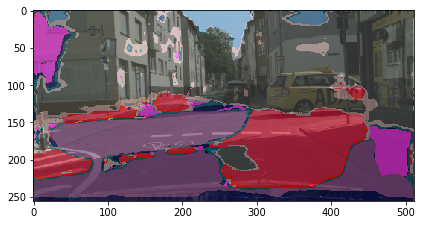

In [29]:
SCALE = 4
#tic = time.time()
#x_val, y_val, filenames = importBatch(500,0,0,'val',SCALE)
#toc = time.time()
#print('Load validation batch:', toc - tic)
def eval_model(model):          
        print(1)
        x_pred = model.predict(x_val_data,verbose=1)        
        new_x=np.argmax(x_pred,axis=3)
        
        """ UPSCALING
        new_new_x = np.zeros((new_x.shape[0],new_x.shape[1]*SCALE,new_x.shape[2]*SCALE))
        
        for i in range(x_pred.shape[0]):
            new_new_x[i]=UpscaleImg(new_x[i],SCALE,0)
            upd_print(("Upscaled %d images" % i))
        print()
        new_new_x=new_new_x.astype(int)"""
        
        new_x=new_x.astype(int)        
        
        """   SAVE
        cityscapesPath = os.environ['CITYSCAPES_DATASET']        
        for i in range(len(filenames)):
            impath = os.path.join(cityscapesPath,'results', filenames[i].split('/')[7]+'.png')           
            imsave(impath, new_new_x[i])
            upd_print("Saved %d images" % i)            
        print()
        toc = time.time()
        print('Save files:', toc -tic) """
        y_val = np.argmax(y_val_data,axis=3)
        score = eval_preds(new_x,y_val)        
        return score
model = load_model('unet_tensorflow.hdf5', custom_objects={'multi_dice_loss': multi_dice_loss})
#with tf.Session() as sess:
x_pred = model.predict(x_val_data[0:1],verbose=1)  
pred_image=np.argmax(x_pred[0],axis=2).astype(int)
pred_image.shape
#y_img = np.argmax(y_val_data[0],axis=2).astype(int)
#y_img.shape
colorImage(x_val_data[0],pred_image, 'classes.txt', 'colors.txt')
#model = load_model('unet_RVsaved1.hdf5')
#print(eval_model(model))
#print(y_val_data.shape)